# Предобработка данных

In [43]:
# Подключение к Google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Специфические преобразования

In [45]:
# PATH ='/content/drive/My Drive/мои временные ряды/' 
PATH=''

In [46]:
# Загрузим набор данных

df = pd.read_csv(PATH+'freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [47]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [48]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [49]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [50]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


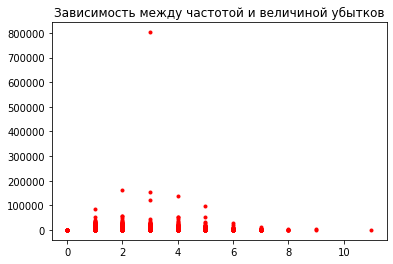

In [51]:

import seaborn as sns
plt.plot(df['ClaimsCount'],df['ClaimAmount'], '.r')
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [52]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

## Общие преобразования

Класс для общих случаев

In [53]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [54]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

Подгружаем данные

In [55]:
data = InsDataFrame_Fr()

In [56]:
data.load_pd(df)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


Преобразовываем параметры

In [58]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [59]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [60]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

Для переменных, содержащих более 2 значений:
- либо упорядочиваем значения,
- либо используем фиктивные переменные (one-hot encoding).

**NB**: В H2O не рекомендуется использовать one-hot encoding. Тем не менее, используем здесь фиктивные переменные, чтобы в дальнейшем сохранить возможность сравнения результатов построенных моделей.

In [61]:
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [63]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [64]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [65]:
df_freq = data.get_pd(col_features+col_target)

In [66]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df_freq[col_features], df_freq.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [69]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df_ac[col_features], df_ac.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

Ссылки на H2O

https://deeplearningrussia.wordpress.com/2019/10/12/intro-to-h2o-ai/


https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

## Установка H2O на Google Colaboratory и инициализация

In [70]:
!apt-get install default-jre

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [71]:
!java -version

'java' is not recognized as an internal or external command,
operable program or batch file.


In [72]:
!pip install h2o

In [73]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,43 secs
H2O_cluster_timezone:,Europe/Minsk
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_Ifl_1elnrw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.819 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Построение GLM для частоты страховых случаев

In [74]:
# Преобразование в H2O-Frame

h2o_train_c = h2o.H2OFrame(pd.concat([x_train_c, y_train_c], axis=1))
h2o_valid_c = h2o.H2OFrame(pd.concat([x_valid_c, y_valid_c], axis=1))
h2o_test_c = h2o.H2OFrame(pd.concat([x_test_c, y_test_c], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [75]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_poisson = H2OGeneralizedLinearEstimator(family = "poisson", link = "Log", nfolds=5)
glm_poisson.train(y="ClaimsCount", x = h2o_train_c.names[1:-1], training_frame = h2o_train_c, validation_frame = h2o_valid_c)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [76]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_poisson.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,poisson,log,"Elastic Net (alpha = 0.5, lambda = 9.667E-5 )",21,19,3,Key_Frame__upload_95639891a6a35ca1770cf239db2648bc.hex


In [77]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_poisson.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.39106002,0.0032708657,0.3958302,0.39174065,0.38781938,0.3881339,0.39177588
1,mean_residual_deviance,1.0614763,0.01967831,1.0929923,1.0626371,1.0431383,1.0467157,1.0618987
2,mse,0.5886495,0.018595379,0.61738706,0.59446186,0.56887454,0.58467716,0.5778471
3,null_deviance,17458.068,244.17842,17852.564,17500.193,17204.537,17371.59,17361.459
4,r2,0.008090373,0.0016860178,0.0076131974,0.010110441,0.006652019,0.009617333,0.006458875
5,residual_deviance,17111.54,243.16261,17519.574,17067.014,16876.934,16998.662,17095.506
6,rmse,0.7671591,0.0120659685,0.78573984,0.77101356,0.7542377,0.7646418,0.76016253
7,rmsle,0.35904264,0.0032601366,0.3640096,0.3593509,0.356338,0.35586932,0.35964543


In [78]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_poisson._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.565659,-1.575867
1,Gender,-0.163708,-0.079349
2,MariStat,-0.114494,-0.041245
3,HasKmLimit,-0.439625,-0.137290
4,BonusMalus,0.012823,0.196838
5,OutUseNb,0.081984,0.057037
6,RiskArea,0.010119,0.022421
7,driver_minage_m,0.000209,0.003928
8,driver_minage_f,0.012369,0.198390
9,driver_minage_m_2,0.000000,0.000000


In [79]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_poisson.coef_norm()
for x in range(len(glm_poisson.cross_validation_models())):
    pmodels[x] = glm_poisson.cross_validation_models()[x].coef_norm()
coef = pd.DataFrame.from_dict(pmodels).round(5)
coef['overall'] = abs(coef['overall'])
coef.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,-1.58475,-1.57461,-1.57114,-1.56948,-1.58076
driver_minage_f,0.19839,0.01515,0.28223,0.18364,0.06668,0.25496
BonusMalus,0.19684,0.19516,0.19569,0.19720,0.19683,0.19678
HasKmLimit,0.13729,-0.12761,-0.12127,-0.13533,-0.14803,-0.15504
driver_minage_f_2,0.11390,0.03026,-0.18642,-0.08562,0.00000,-0.17161
VehUsage_Professional,0.10578,0.09059,0.10688,0.10593,0.09462,0.10738
VehUsage_Private,0.09012,-0.11088,-0.09145,-0.09240,-0.09138,-0.09845
Gender,0.07935,-0.03488,-0.08726,-0.08407,-0.03828,-0.10306
VehUsage_Professional run,0.06599,0.06377,0.05745,0.06841,0.05627,0.07418
OutUseNb,0.05704,0.06286,0.05191,0.06917,0.04788,0.05336


In [80]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

c_train_pred = glm_poisson.predict(h2o_train_c).as_data_frame()
c_valid_pred = glm_poisson.predict(h2o_valid_c).as_data_frame()
c_test_pred = glm_poisson.predict(h2o_test_c).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [81]:
# Сохранение обученной модели

model_glm_poisson = h2o.save_model(model=glm_poisson, path=PATH, force=True)

In [82]:
model_glm_poisson

'C:\\Users\\Ifl\\Documents\\GitHub\\ML-in-business\\lesson7\\GLM_model_python_1605640470658_1'

## Построение GLM для среднего убытка

In [83]:
# Преобразование в H2O-Frame

h2o_train_ac = h2o.H2OFrame(pd.concat([x_train_ac, y_train_ac], axis=1))
h2o_valid_ac = h2o.H2OFrame(pd.concat([x_valid_ac, y_valid_ac], axis=1))
h2o_test_ac = h2o.H2OFrame(pd.concat([x_test_ac, y_test_ac], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_gamma = H2OGeneralizedLinearEstimator(family = "gamma", link = "Log", nfolds=5)
glm_gamma.train(y="AvgClaim", x = h2o_train_ac.names[1:-1], training_frame = h2o_train_ac, validation_frame = h2o_valid_ac)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [85]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_gamma.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gamma,log,"Elastic Net (alpha = 0.5, lambda = 2.602E-4 )",21,19,3,Key_Frame__upload_8db5344ddd3899a614c93f88dd0240e8.hex


In [86]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_gamma.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1191.4653,103.09128,1158.7261,1246.6659,1077.1641,1340.1233,1134.6471
1,mean_residual_deviance,2.0995646,0.16435589,2.012239,2.1518319,1.9588151,2.364145,2.0107918
2,mse,1.5547402E7,2.0900786E7,4878877.5,1.0562697E7,3701095.5,5.2645184E7,5949155.5
3,null_deviance,3186.126,295.4349,3049.2932,3195.895,2943.8708,3689.7075,3051.8633
4,r2,-0.007936834,0.013611115,-4.834408E-4,0.0027758924,-0.03048495,-6.118485E-4,-0.010879826
5,residual_deviance,3195.158,267.66437,3044.5178,3176.104,2989.1519,3657.3323,3108.6838
6,rmse,3415.4922,2202.7866,2208.818,3250.0303,1923.8231,7255.7,2439.089
7,rmsle,1.7664202,0.025842596,1.7711135,1.7566987,1.8070996,1.7370944,1.7600949


In [87]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_gamma._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,7.310145,7.017288
1,Gender,-0.314623,-0.152506
2,MariStat,0.299338,0.110533
3,HasKmLimit,-0.066859,-0.016827
4,BonusMalus,-0.002345,-0.039579
5,OutUseNb,-0.021085,-0.015749
6,RiskArea,0.030396,0.067861
7,driver_minage_m,-0.021733,-0.397791
8,driver_minage_f,0.012161,0.187589
9,driver_minage_m_2,0.000179,0.268589


In [88]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_gamma.coef_norm()
for x in range(len(glm_gamma.cross_validation_models())):
    pmodels[x] = glm_gamma.cross_validation_models()[x].coef_norm()
coef_ac = pd.DataFrame.from_dict(pmodels).round(5)
coef_ac['overall'] = abs(coef['overall'])
coef_ac.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,1.57587,7.02323,7.00198,7.04853,6.97818,7.02452
driver_minage_f,0.19839,0.14470,0.20230,0.24305,0.14196,0.08767
BonusMalus,0.19684,-0.05462,-0.02523,-0.03958,0.00758,-0.07742
HasKmLimit,0.13729,-0.00674,-0.02025,-0.01323,-0.01459,-0.02933
driver_minage_f_2,0.11390,-0.15150,-0.19778,-0.21868,-0.15107,-0.10061
VehUsage_Professional,0.10578,0.00000,-0.01633,0.00000,-0.00557,-0.00947
VehUsage_Private,0.09012,-0.00390,0.00000,0.01476,0.00000,0.00000
Gender,0.07935,-0.11822,-0.09585,-0.20505,-0.11637,-0.19022
VehUsage_Professional run,0.06599,-0.02545,-0.06575,-0.04678,-0.02985,-0.05183
OutUseNb,0.05704,-0.03929,-0.01126,-0.02103,0.01845,-0.02026


In [89]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ac_train_pred = glm_gamma.predict(h2o_train_ac).as_data_frame()
ac_valid_pred = glm_gamma.predict(h2o_valid_ac).as_data_frame()
ac_test_pred = glm_gamma.predict(h2o_test_ac).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [90]:
# Сохранение обученной модели

model_glm_gamma = h2o.save_model(model=glm_gamma, path=PATH, force=True)

In [91]:
model_glm_gamma

'C:\\Users\\Ifl\\Documents\\GitHub\\ML-in-business\\lesson7\\GLM_model_python_1605640470658_2'

## Использование GLM моделей

In [92]:
h2o_df = h2o.H2OFrame(df_freq[col_features])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [93]:
df['CountPredicted'] = glm_poisson.predict(h2o_df).as_data_frame()
df['AvgClaimPredicted'] = glm_gamma.predict(h2o_df).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [94]:
df['BurningCost'] = df.CountPredicted * df.AvgClaimPredicted
df[['CountPredicted', 'AvgClaimPredicted', 'BurningCost']].head()

,CountPredicted,AvgClaimPredicted,BurningCost
0,0.268689,1087.936414,292.316704
1,0.268689,1087.936414,292.316704
2,0.240122,1146.063987,275.195142
3,0.200097,1127.364931,225.582287
4,0.168869,1106.883916,186.918109


# * Домашнее задание: GLM для прогнозирования наступления страхового случая

In [106]:
# Разбиение датасета на train/val/test

df_ind = data.get_pd(col_features+['ClaimInd'])

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df_ind[col_features], 
                                                                    df_ind.ClaimInd, 
                                                                    test_size=0.3, 
                                                                    random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, 
                                                                    y_test_ind, 
                                                                    test_size=0.5, 
                                                                    random_state=1)

In [107]:
# Преобразование в H2O-Frame

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [114]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train_ind['ClaimInd'] = h2o_train_ind['ClaimInd'].asfactor()
h2o_valid_ind['ClaimInd'] = h2o_valid_ind['ClaimInd'].asfactor()
h2o_test_ind['ClaimInd'] = h2o_test_ind['ClaimInd'].asfactor()
h2o_train_ind.describe()

Rows:80608
Cols:23




,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,driver_minage_m_2,driver_minage_f_2,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,ClaimInd
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,2.0,0.0,0.0,0.0,50.0,0.0,1.0,18.0,18.0,324.0,324.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,51.75058306867794,0.37723302897975386,0.15326022231044065,0.10951766574037317,59.2143831877732,0.2555825724493842,7.865844581183003,37.783830389043054,28.558604605002078,1782.2023000198485,1072.857904922587,0.3375719531560143,0.5192908892417626,0.12480150853513299,0.018335649067090114,0.023508832870186583,0.028570365224295357,0.010879813418023025,0.06702808654227868,0.6550466454942437,0.21485460500198492,0.00011165144898769353,
maxs,52.0,1.0,1.0,1.0,185.0,5.0,13.0,70.0,70.0,4900.0,4900.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
sigma,2.1897882399518807,0.4846970036179395,0.3602403870980358,0.312289539523243,15.350310097817191,0.6957073250686125,2.2156304665763513,18.830529999996052,16.039551101003465,1561.3224499201433,1257.583822951236,0.47288466222070463,0.4996308221508914,0.3304957594996283,0.13416287243220965,0.1515138687992299,0.16659664993332923,0.10373801898571612,0.2500721855022369,0.47535601495946367,0.41072399063581844,0.010566000564092022,
zeros,0,50200,68254,71780,0,67618,0,0,0,0,0,53397,38749,70548,79130,78713,78305,79731,75205,27806,63289,80599,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,52.0,1.0,0.0,0.0,50.0,0.0,10.0,18.0,55.0,324.0,3025.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,52.0,0.0,0.0,0.0,50.0,0.0,2.0,70.0,18.0,4900.0,324.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,52.0,1.0,1.0,0.0,90.0,1.0,10.0,18.0,61.0,324.0,3721.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [115]:
h2o_train_ind.names

['driver_minexp',
 'Gender',
 'MariStat',
 'HasKmLimit',
 'BonusMalus',
 'OutUseNb',
 'RiskArea',
 'driver_minage_m',
 'driver_minage_f',
 'driver_minage_m_2',
 'driver_minage_f_2',
 'VehUsage_Private',
 'VehUsage_Private+trip to office',
 'VehUsage_Professional',
 'VehUsage_Professional run',
 'SocioCateg_CSP1',
 'SocioCateg_CSP2',
 'SocioCateg_CSP3',
 'SocioCateg_CSP4',
 'SocioCateg_CSP5',
 'SocioCateg_CSP6',
 'SocioCateg_CSP7',
 'ClaimInd']

In [121]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_binomial = H2OGeneralizedLinearEstimator(family = "binomial", link = "logit", nfolds=5)
# glm_poisson.train(y="ClaimInd", x = h2o_train_ind.names[1:-1], training_frame = h2o_train_ind, validation_frame = h2o_valid_ind)
glm_binomial.train(y="ClaimInd", 
                  x = h2o_train_ind.names, 
                  training_frame = h2o_train_ind, 
                  validation_frame = h2o_valid_ind)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [122]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, 
# количество использованных объясняющих переменных
glm_binomial.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 2.368E-5 )",22,22,3,py_4_sid_9810


In [123]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_binomial.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.5518432,0.06726691,0.56439275,0.5603609,0.5971652,0.6011454,0.43615174
1,auc,0.56489027,0.0053428174,0.5575151,0.56194013,0.57137424,0.5677238,0.5658979
2,aucpr,0.11543474,0.0038656008,0.110213116,0.114008024,0.114430904,0.11895666,0.119564995
3,err,0.44815677,0.06726691,0.43560722,0.4396391,0.40283477,0.3988546,0.56384826
4,err_count,7224.6,1082.7245,7005.0,7065.0,6480.0,6477.0,9096.0
5,f0point5,0.13522266,0.005629201,0.12918854,0.13325378,0.13496731,0.14446549,0.13423817
6,f1,0.1880278,0.006599801,0.17983843,0.18540297,0.18572506,0.19670098,0.1924716
7,f2,0.30922958,0.017882675,0.29581696,0.3046147,0.2976718,0.30810475,0.3399398
8,lift_top_group,1.6096076,0.23072304,1.8221714,1.5885464,1.4801933,1.3059558,1.8511713
9,logloss,0.31110063,0.0064375824,0.3054853,0.3093358,0.30533567,0.32007024,0.3152761


In [124]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_binomial._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-1.512545,-2.280251
1,driver_minexp,-0.018747,-0.041053
2,Gender,-0.083078,-0.040268
3,MariStat,-0.075981,-0.027371
4,HasKmLimit,-0.368641,-0.115123
5,BonusMalus,0.006301,0.096715
6,OutUseNb,0.062829,0.043711
7,RiskArea,0.009380,0.020783
8,driver_minage_m,-0.003255,-0.061289
9,driver_minage_f,-0.000140,-0.002245


In [126]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_binomial.coef_norm()
for x in range(len(glm_binomial.cross_validation_models())):
    pmodels[x] = glm_binomial.cross_validation_models()[x].coef_norm()
coef = pd.DataFrame.from_dict(pmodels).round(5)
coef['overall'] = abs(coef['overall'])
coef.sort_values('overall',ascending=False)

,overall,0,1,2,3,4
Intercept,2.28025,-2.27360,-2.27870,-2.27204,-2.29269,-2.28557
HasKmLimit,0.11512,-0.11886,-0.12181,-0.10186,-0.12012,-0.11305
BonusMalus,0.09671,0.08630,0.09358,0.09148,0.09804,0.10993
VehUsage_Professional,0.07667,0.08340,0.07318,0.07961,0.08056,0.08494
VehUsage_Private,0.06834,-0.05734,-0.07141,-0.06068,-0.06918,-0.06135
driver_minage_m,0.06129,-0.23429,-0.07335,-0.06641,-0.10897,-0.05908
OutUseNb,0.04371,0.04820,0.04090,0.03482,0.04882,0.04582
driver_minexp,0.04105,-0.04205,-0.03883,-0.04637,-0.04658,-0.03078
Gender,0.04027,-0.09094,-0.04045,-0.05115,-0.05708,-0.01548
VehUsage_Professional run,0.04002,0.05164,0.04250,0.03685,0.03716,0.03873


In [127]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ind_train_pred = glm_binomial.predict(h2o_train_ind).as_data_frame()
ind_valid_pred = glm_binomial.predict(h2o_valid_ind).as_data_frame()
ind_test_pred = glm_binomial.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [142]:
# ind_train_pred['predict'].to_list()

[1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,


In [140]:
# h2o_train_ind.as_data_frame()['ClaimInd'].tolist()

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [104]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [146]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок
y_true = h2o_train_ind.as_data_frame()['ClaimInd'].tolist()
y_pred = ind_train_pred['predict'].to_list()
accuracy_score(y_true, y_pred)

0.5415839618896388

In [147]:
f1_score(h2o_train_ind.as_data_frame()['ClaimInd'].tolist(), ind_train_pred['predict'].to_list())

0.1861151491123739

In [148]:
confusion_matrix(h2o_train_ind.as_data_frame()['ClaimInd'].tolist(), ind_train_pred['predict'].to_list())

array([[39431, 33542],
       [ 3410,  4225]], dtype=int64)

Какие проблемы вы здесь видите? Как можно улучшить данный результат?

"угадали" 39431+4225, не угадали 33542+3410
очень много ложноположительных (предсказали убыток, хотя его нет)

In [150]:
y_true = h2o_test_ind.as_data_frame()['ClaimInd'].tolist()
y_pred = ind_test_pred['predict'].to_list()
accuracy_score(y_true, y_pred), f1_score(y_true, y_pred), confusion_matrix(y_true, y_pred)

(0.542375824939215,
 0.18446301454658,
 array([[8475, 7174],
        [ 731,  894]], dtype=int64))

In [151]:
y_true = h2o_valid_ind.as_data_frame()['ClaimInd'].tolist()
y_pred = ind_valid_pred['predict'].to_list()
accuracy_score(y_true, y_pred), f1_score(y_true, y_pred), confusion_matrix(y_true, y_pred)

(0.5444335089445956,
 0.18582514226590793,
 array([[8506, 7158],
        [ 711,  898]], dtype=int64))